# 1. Introduction

This project aims to build a book recommendation system using collaborative filtering techniques. The dataset consists of user ratings for various books, alongside metadata such as book titles, authors, and publication years. The goal is to suggest books that users might enjoy based on their past reading preferences.

Key Steps:
 - [**Data Preparation**](#data-preparation): Cleaning and preprocessing the raw data, including filtering out users with fewer than 200 ratings and books with fewer than 25 ratings. This ensures a robust dataset for training the recommendation model.

 - [**Creating Pivot Table**](#compressing-the-pivot-table): Constructing a user-item interaction matrix where rows represent book titles and columns represent user IDs. Each cell in the matrix contains the rating given by a user to a book.

 - [**Model Training**](#3-ml-modelling): Using the Nearest Neighbors algorithm to find similar books based on user ratings. The model is trained on the compressed pivot table to efficiently handle sparse data.

 - [**Saving Models and Data**](#4-saving-models-and-data): Persisting the trained model and preprocessed data to disk for later use in generating recommendations.

 - [**Making Recommendations**](#5-recommendation-function): Implementing a function to recommend books based on a given book title. This function uses the trained model to find and display similar books.

Import packages and libraries

In [105]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
import gdown

import warnings
warnings.simplefilter('ignore')
plt.style.use('ggplot')

# 2. Data Preparation

 **Downloading and Loading Data**:

The dataset is downloaded from a specified Google Drive folder. It includes three CSV files containing book metadata, user information, and book ratings.

**Data Cleaning and Filtering**:

 - **Books Data**: The books dataset is filtered to include only necessary columns: ISBN, title, author, year of publication, publisher, and image URL.
 - **Users Data**: The users dataset is filtered and renamed for clarity.
 - **Ratings Data**: The ratings dataset is filtered to include users who have rated at least 200 books. This ensures that the model is trained on active users, providing more reliable recommendations.

**Merging Data**:
The ratings data is merged with the books data to associate ratings with book metadata.

**Filtering Rare Books**:
Books with fewer than 25 ratings are filtered out to ensure that the recommendations are based on widely-read books, which improves recommendation accuracy.

In [2]:
gdown.download_folder("https://drive.google.com/drive/u/1/folders/1qLH0F0FcnUp95Ximwz-P961_BpfB4LDP", quiet=True)

Retrieving folder contents


Processing file 1G1rSROke65VAYY3ebHVJSGcmEr2lBZy0 BX-Book-Ratings.csv
Processing file 10qSNLQeiUhCXLsf0TludrtbifaQVGfB4 BX-Books.csv
Processing file 1yGs8Klh_e6eniCG9rmm_S6MDohW0D7QG BX-Users.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1G1rSROke65VAYY3ebHVJSGcmEr2lBZy0
To: c:\grow\projects\RecommendationSys\datastore\BX-Book-Ratings.csv
100%|██████████| 30.7M/30.7M [00:04<00:00, 6.84MB/s]
Downloading...
From: https://drive.google.com/uc?id=10qSNLQeiUhCXLsf0TludrtbifaQVGfB4
To: c:\grow\projects\RecommendationSys\datastore\BX-Books.csv
100%|██████████| 77.8M/77.8M [00:11<00:00, 6.71MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yGs8Klh_e6eniCG9rmm_S6MDohW0D7QG
To: c:\grow\projects\RecommendationSys\datastore\BX-Users.csv
100%|██████████| 12.3M/12.3M [00:01<00:00, 6.74MB/s]
Download completed


['c:\\grow\\projects\\RecommendationSys\\datastore\\BX-Book-Ratings.csv',
 'c:\\grow\\projects\\RecommendationSys\\datastore\\BX-Books.csv',
 'c:\\grow\\projects\\RecommendationSys\\datastore\\BX-Users.csv']

Load books data

In [3]:
raw_books = pd.read_csv("datastore/BX-Books.csv", on_bad_lines='skip', encoding='latin-1', sep=";")
raw_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [4]:
raw_books.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')

In [5]:
# fiters raw books by column to select relevant featues
books = raw_books[["ISBN", "Book-Title", "Book-Author", "Year-Of-Publication", "Publisher", "Image-URL-L"]]

In [98]:
# rename feature names
books.rename(columns={"Book-Title": "title",
             "Year-Of-Publication": "year",
              "Image-URL-L": "image_url",
              "Book-Author": "author",
              "Publisher": "publisher",
              }, inplace=True)

books.head()

,ISBN,title,author,year,publisher,image_url
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...


In [7]:
books.shape

(271360, 6)

Load and explore `User` data

In [8]:
users = pd.read_csv("./datastore/BX-Users.csv", sep=";", encoding='latin-1')
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


rename column user id

In [9]:
users.rename(columns={"User-ID": "user_id"}, inplace=True)
users.head()

,user_id,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [10]:
users.shape

(278858, 3)

Load and explore `Ratings` data

In [11]:
ratings = pd.read_csv("./datastore/BX-Book-Ratings.csv", sep=";", encoding='latin-1')
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


rename User-ID and book rating

In [12]:
ratings.rename(columns={"User-ID": "user_id", "Book-Rating": "rating"}, inplace=True)
ratings.head()

,user_id,ISBN,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [13]:
ratings.shape

(1149780, 3)

In [100]:
print("ratings distribution in %\n")
distribution_of_ratings = ratings['rating'].value_counts(normalize=True) * 100
distribution_of_ratings

ratings distribution in %



rating
0     74.656150
8      5.984957
10     5.382557
9      4.463412
7      4.004125
5      3.014088
6      1.715837
4      0.338163
3      0.217986
2      0.119987
1      0.102738
Name: proportion, dtype: float64

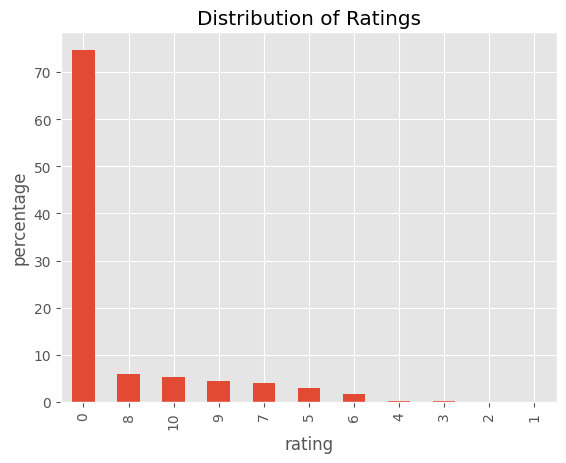

In [106]:
distribution_of_ratings.plot(kind='bar')
plt.title('Distribution of Ratings')
plt.ylabel('percentage');

From the chart above, 74% of books are either not rated or users had no interest in these book. Only a little above 5% got full rating of 10

Number of users who have rated at least 200 books. Using 200 books as the minimum for active readers.

In [15]:
is_above_200 = ratings['user_id'].value_counts() >= 200
least_200_index = is_above_200[is_above_200].index
least_200_index

Index([ 11676, 198711, 153662,  98391,  35859, 212898, 278418,  76352, 110973,
       235105,
       ...
        28634,  59727, 268622, 188951, 225595,  83671, 252827,  99955,  36554,
        26883],
      dtype='int64', name='user_id', length=905)

In [17]:
len(least_200_index)

905

There are 905 active unique users who have rated at least 200 books.

Next,  filter the ratings dataFrame to include only those ratings made by users who have rated at least 200 books

In [18]:
ratings = ratings[ratings['user_id'].isin(least_200_index)]

In [19]:
ratings.head()

,user_id,ISBN,rating
1456,277427,002542730X,10
1457,277427,0026217457,0
1458,277427,003008685X,8
1459,277427,0030615321,0
1460,277427,0060002050,0


Next merge rating with books on `ISBN`

In [20]:
books.head()

,ISBN,title,author,year,publisher,image_url
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...


In [21]:
book_ratings = ratings.merge(books, on='ISBN')
book_ratings.head()

,user_id,ISBN,rating,title,author,year,publisher,image_url
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...
1,277427,0026217457,0,Vegetarian Times Complete Cookbook,Lucy Moll,1995,John Wiley &amp; Sons,http://images.amazon.com/images/P/0026217457.0...
2,277427,003008685X,8,Pioneers,James Fenimore Cooper,1974,Thomson Learning,http://images.amazon.com/images/P/003008685X.0...
3,277427,0030615321,0,"Ask for May, Settle for June (A Doonesbury book)",G. B. Trudeau,1982,Henry Holt &amp; Co,http://images.amazon.com/images/P/0030615321.0...
4,277427,0060002050,0,On a Wicked Dawn (Cynster Novels),Stephanie Laurens,2002,Avon Books,http://images.amazon.com/images/P/0060002050.0...


In [22]:
book_ratings.shape

(488742, 8)

In [23]:
book_ratings.isna().sum()

user_id      0
ISBN         0
rating       0
title        0
author       1
year         0
publisher    2
image_url    3
dtype: int64

In [24]:
count_book_ratings = book_ratings.groupby('title')['rating'].count().reset_index()
count_book_ratings.head()

,title,rating
0,A Light in the Storm: The Civil War Diary of ...,2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1


In [25]:
count_book_ratings.rename(columns={'rating': 'rating_count'}, inplace=True)

In [26]:
count_book_ratings.columns

Index(['title', 'rating_count'], dtype='object')

In [27]:
merged_data = book_ratings.merge(count_book_ratings, on='title')
merged_data.sample(5)

,user_id,ISBN,rating,title,author,year,publisher,image_url,rating_count
266647,153662,0688168914,0,From This Day Forward,Cokie Roberts,2000,William Morrow &amp; Company,http://images.amazon.com/images/P/0688168914.0...,5
102989,55492,0679441018,0,Memnoch the Devil : The Vampire Chronicles (Va...,ANNE RICE,1995,Knopf,http://images.amazon.com/images/P/0679441018.0...,28
317094,184299,0060914254,0,A Loss for Words : The Story of Deafness in a ...,Lou Ann Walker,1987,Perennial,http://images.amazon.com/images/P/0060914254.0...,1
471935,265313,0061056146,0,Fires of Eden,Dan Simmons,1995,Harper Mass Market Paperbacks (Mm),http://images.amazon.com/images/P/0061056146.0...,5
307400,177458,1552093115,0,Off the Wall: Graffiti for the Soul,Ernie J. Zelinski,1999,Firefly Books Ltd,http://images.amazon.com/images/P/1552093115.0...,4


In [28]:
merged_data['rating_count'].describe()

count    488742.000000
mean         21.173474
std          37.189202
min           1.000000
25%           2.000000
50%           6.000000
75%          22.000000
max         365.000000
Name: rating_count, dtype: float64

Fromm the frame above, the **average** **`rating_count`** is **21.2**. So, 25 will be used to filter merged_data by above average rating count.

In [29]:
merged_data = merged_data[merged_data['rating_count']>=25]

In [30]:
merged_data.columns

Index(['user_id', 'ISBN', 'rating', 'title', 'author', 'year', 'publisher',
       'image_url', 'rating_count'],
      dtype='object')

In [31]:
books_pivot_table = merged_data.pivot_table(columns='user_id', index='title', values='rating')
books_pivot_table.sample(5)

user_id,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
Nerilka's Story (Dragonriders of Pern (Paperback)),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Starship Troopers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dead in the Water,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Five Quarters of the Orange,NaN,NaN,8.0,NaN,0.0,NaN,NaN,NaN,6.0,NaN,...,6.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
Puerto Vallarta Squeeze,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
books_pivot_table.shape

(2298, 901)

### Compressing the Pivot Table

The pivot table is converted to a Compressed Sparse Row (CSR) matrix to efficiently handle the sparsity of the data, which is common in recommendation systems. fill NA values with 0 and compress table using the `Compress Sparse Row matirx` csr_matrix function.

In [33]:
books_pivot_table.fillna(0, inplace=True)
books_pivot_table.sample(7)

user_id,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
A Place Called Freedom,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"The Dragon Reborn (The Wheel of Time, Book 3)",0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Blue Moon,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Wild Horses,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Leaving Home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Field of Thirteen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Beauty's Release,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
compressed_table = csr_matrix(books_pivot_table)
compressed_table.size

27194

# 3. ML Modelling

Training the Nearest Neighbors Model:
A Nearest Neighbors model is trained on the compressed pivot table. This model will be used to find books that are similar to a given book based on user ratings.

In [35]:
from sklearn.neighbors import NearestNeighbors

nn_model = NearestNeighbors(algorithm='brute')
nn_model.fit(compressed_table)
distances, recommended_users = nn_model.kneighbors(books_pivot_table.iloc[254, :].values.reshape(1,-1), n_neighbors=6)

In [36]:
recommended_users, distances

(array([[ 254,  774, 2176,  252,  130,  404]], dtype=int64),
 array([[ 0.        , 13.22875656, 14.52583905, 15.62049935, 16.03121954,
         16.15549442]]))

In [37]:
for i in range(len(distances)):
  print(books_pivot_table.index[recommended_users[i]])

Index(['Bloodstream', 'Honor Among Thieves',
       'Under the Tuscan Sun : At Home in Italy',
       'Blood and Gold (Rice, Anne, Vampire Chronicles.)', 'Always a Thief',
       'Critical Judgment'],
      dtype='object', name='title')


In [38]:
book_titles = books_pivot_table.index
np.random.choice(book_titles, 5)

array(['Lasher: Lives of the Mayfair Witches (Lives of the Mayfair Witches)',
       'How the Garcia Girls Lost Their Accents (Plume Contemporary Fiction)',
       'A Wind in the Door', 'The House on Hope Street',
       "Perfect Evil (Maggie O'Dell Novels (Paperback))"], dtype=object)

In [39]:
compressed_table.toarray().shape

(2298, 901)

# 4. Saving Models and Data

The trained model and preprocessed data (e.g., the pivot table and book metadata) are saved to disk. This allows for easy loading and use of the model for generating recommendations without retraining.

In [86]:
import os
from joblib import dump

os.makedirs('artifacts', exist_ok=True)

dump(nn_model, 'artifacts/model.pkl')
dump(book_titles, 'artifacts/book_titles.pkl')
dump(merged_data, 'artifacts/merged_data.pkl')
dump(books_pivot_table, 'artifacts/books_pivot_table.pkl')

['artifacts/books_pivot_table.pkl']

# 5. Recommendation Function
A function is implemented to generate book recommendations based on a given book title. The function:

 - Loads the trained model and pivot table.
 - Finds the index of the given book in the pivot table.
 - Uses the Nearest Neighbors model to find similar books.
 - Prints the recommended book titles.

The recommendations are based on the similarity of user ratings between books. If the book is not found in the dataset, the function handles this gracefully by informing the user.

In [77]:
def recommend_books(book_name: str):
	model = pickle.load(open('artifacts/model.pkl', 'rb'))
	book_pivot = pickle.load(open('artifacts/books_pivot_table.pkl', 'rb'))
	book_idx = np.where(books_pivot_table.index == book_name)[0][0]
	data = books_pivot_table.iloc[book_idx].values.reshape(1,-1)
	distances, recommended_users = model.kneighbors(data, n_neighbors=7)

	for i in range(len(distances)):
		book_title = book_pivot.index[recommended_users[i]]

	print(f'Book recommendations for "{book_name}":')
	for title in book_title[1:]:
		print(title)
	print()

recommend_books('2010: Odyssey Two')
recommend_books('Harry Potter and the Chamber of Secrets (Book 2)')
recommend_books('Trunk Music (Detective Harry Bosch Mysteries)')

Book recommendations for "2010: Odyssey Two":
False Pretenses
Another City, Not My Own: A Novel in the Form of a Memoir
The Bridge Across Forever
Man From St Petersburg
Acts of Love
Night Moves (Tom Clancy's Net Force, No. 3)

Book recommendations for "Harry Potter and the Chamber of Secrets (Book 2)":
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Sorcerer's Stone (Book 1)
The Shelters of Stone (Earth's Children Series, No 5)
The Mammoth Hunters (Auel, Jean M. , Earth's Children.)
Before and After

Book recommendations for "Trunk Music (Detective Harry Bosch Mysteries)":
Acts of Love
House
The Apocalypse Watch
Night Moves (Tom Clancy's Net Force, No. 3)
The Legend of Bagger Vance
Texas Rich

